### Import libraries and dataset

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error

# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [79]:
file_path = "../data/ObesityDataSet_Clean.csv"
df = pd.read_csv(file_path)

### Model preparation and feature engineering

In [ ]:
def dataset_setup(df, all_attributes=False):
    if(all_attributes):
        X = df.drop(columns="Weight")

    else:
        #attributes_used = ["Age", "Gender", "Height", "family_history_with_overweight", "CAEC"]
        attributes_used = df.drop(columns=["Weight", "CALC", "MTRANS", "SMOKE", "SCC", "CH2O", "CAEC"]).columns
        X = df[attributes_used]

    return X, df["Weight"]

X, y = dataset_setup(df, all_attributes=True)
X.head()

,Gender,Age,Height,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation,Overweight_Level_II


#### One out of K encoding

In [90]:
NOBD = pd.Categorical(X["NObeyesdad"], ordered=True)

print(NOBD)

['Normal_Weight', 'Normal_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', ..., 'Obesity_Type_III', 'Obesity_Type_III', 'Obesity_Type_III', 'Obesity_Type_III', 'Obesity_Type_III']
Length: 2111
Categories (7, object): ['Insufficient_Weight' < 'Normal_Weight' < 'Obesity_Type_I' < 'Obesity_Type_II' < 'Obesity_Type_III' < 'Overweight_Level_I' < 'Overweight_Level_II']


In [81]:
categorical_attributes = X.drop(columns=["Age", "Height"]).columns
X = pd.get_dummies(X, columns=categorical_attributes, drop_first=True, dtype=int)
X.head()

,Age,Height,Gender_Male,family_history_with_overweight_yes,FAVC_yes,FCVC_2,FCVC_3,NCP_2,NCP_3,FAF_1,FAF_2,FAF_3,TUE_1,TUE_2,NObeyesdad_Normal_Weight,NObeyesdad_Obesity_Type_I,NObeyesdad_Obesity_Type_II,NObeyesdad_Obesity_Type_III,NObeyesdad_Overweight_Level_I,NObeyesdad_Overweight_Level_II
0,21,1.62,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0
1,21,1.52,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0
2,23,1.80,1,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0
3,27,1.80,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0
4,22,1.78,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [82]:
def bmplot(yt, xt, X):
    """
    Function plots matrix X as image with white background, black grid lines, and dark blue for selected cells.
    """
    plt.imshow(X, interpolation="none", cmap="Blues", aspect="equal", vmin=0, vmax=1)
    plt.xticks(range(0, len(xt)), xt)
    plt.yticks(range(0, len(yt)), yt)
    plt.gca().set_facecolor("white")
    for i in range(0, len(yt)):
        plt.axhline(i - 0.5, color="black")
    for i in range(0, len(xt)):
        plt.axvline(i - 0.5, color="black")
    plt.grid(False)
    
def plot_seq_feature_results(fold_results, feature_names):
    num_folds = len(fold_results)

    for i, res in enumerate(fold_results):
        fig, axes = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={"width_ratios": [2, 1]})
        
        # Left: MSE progression
        axes[0].plot(range(1, len(res["mse"])+1), res["mse"], marker="o")
        axes[0].set_title(f"Fold {i+1}: MSE vs #features")
        axes[0].set_xlabel("Iteration")
        axes[0].set_ylabel("MSE")

        # Right: Heatmap of feature selection order using bmplot
        grid = np.zeros((len(feature_names), len(res["features"])))
        for j, feat in enumerate(res["features"]):
            grid[feature_names.index(feat), j:] = 1

        plt.sca(axes[1])
        bmplot(feature_names, list(range(1, len(res["features"])+1)), grid)
        axes[1].set_title(f"Fold {i+1}: feature selection path")
        axes[1].set_xlabel("Iteration")
        axes[1].set_ylabel("Features")

        plt.tight_layout()
        plt.show()

    # Final summary heatmap
    fig, axes = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={"width_ratios": [2, 1]})

    # Left: Outer test MSEs
    outer_mses = [res["outer_test_mse"] for res in fold_results]
    axes[0].bar(range(1, num_folds + 1), outer_mses, color='tab:blue')
    axes[0].set_title("Outer test MSEs per fold")
    axes[0].set_xlabel("Fold")
    axes[0].set_ylabel("Outer test MSE")
    axes[0].grid(True, axis='y')
    
    # Right: Feature usage summary
    summary = np.zeros((len(feature_names), num_folds))
    for i, res in enumerate(fold_results):
        for feat in res["features"]:
            summary[feature_names.index(feat), i] = 1

    bmplot(feature_names, range(num_folds), summary)
    axes[1].set_title("Feature usage across folds")
    axes[1].set_xlabel("Outer folds")
    axes[1].set_ylabel("Features")
    plt.tight_layout()
    plt.show()

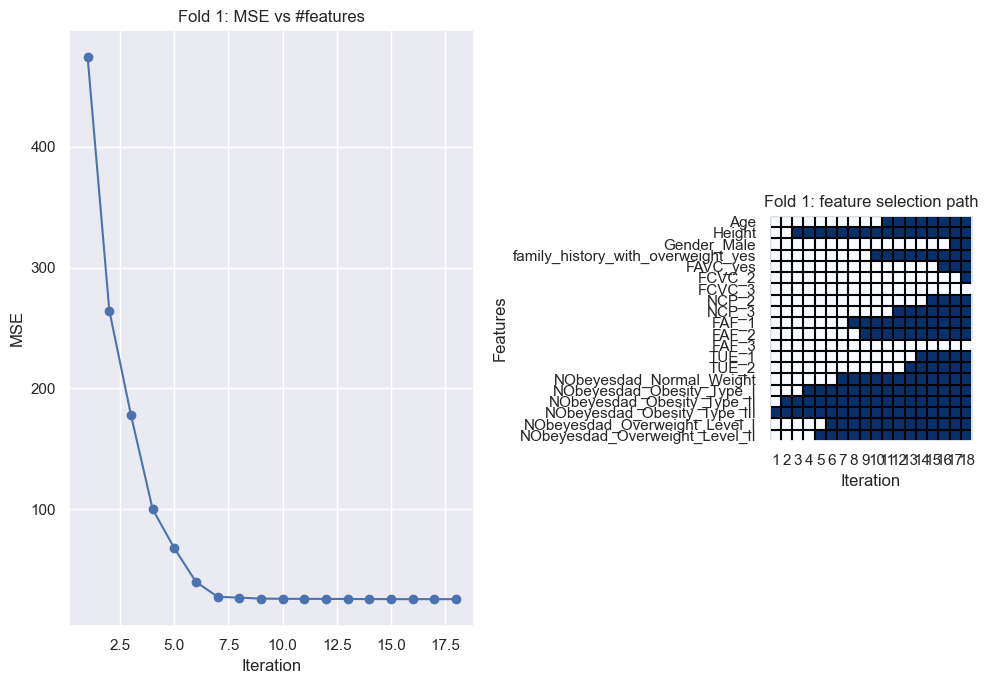

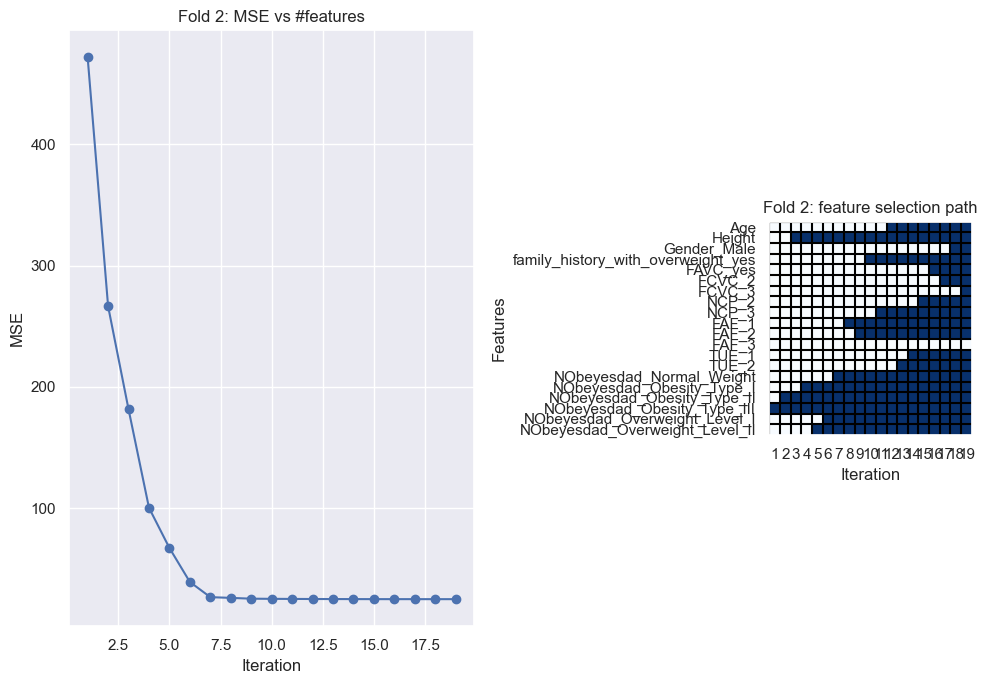

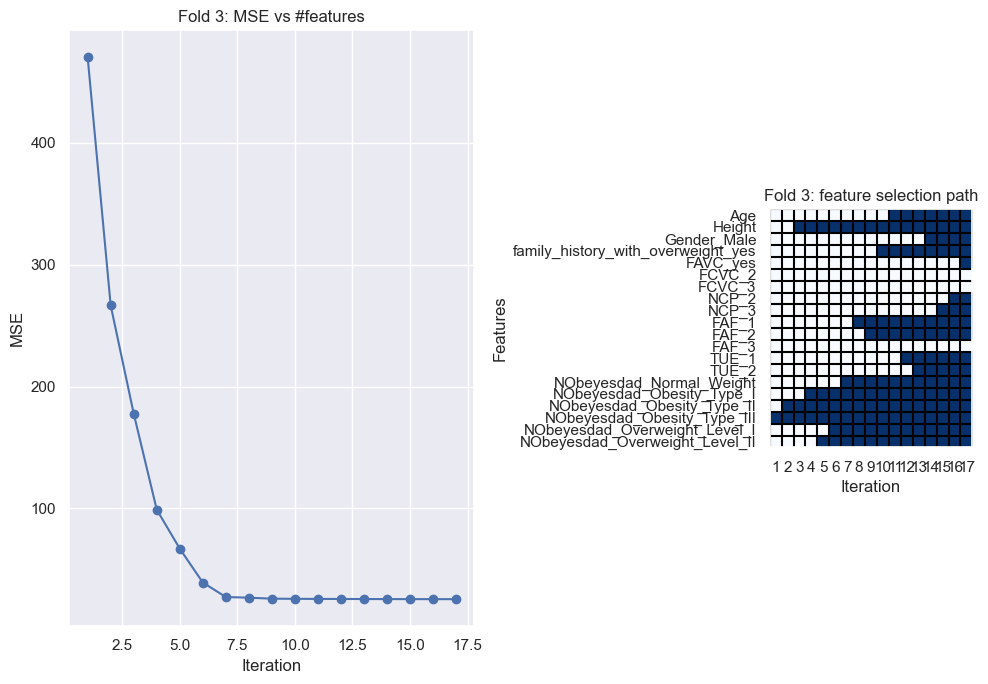

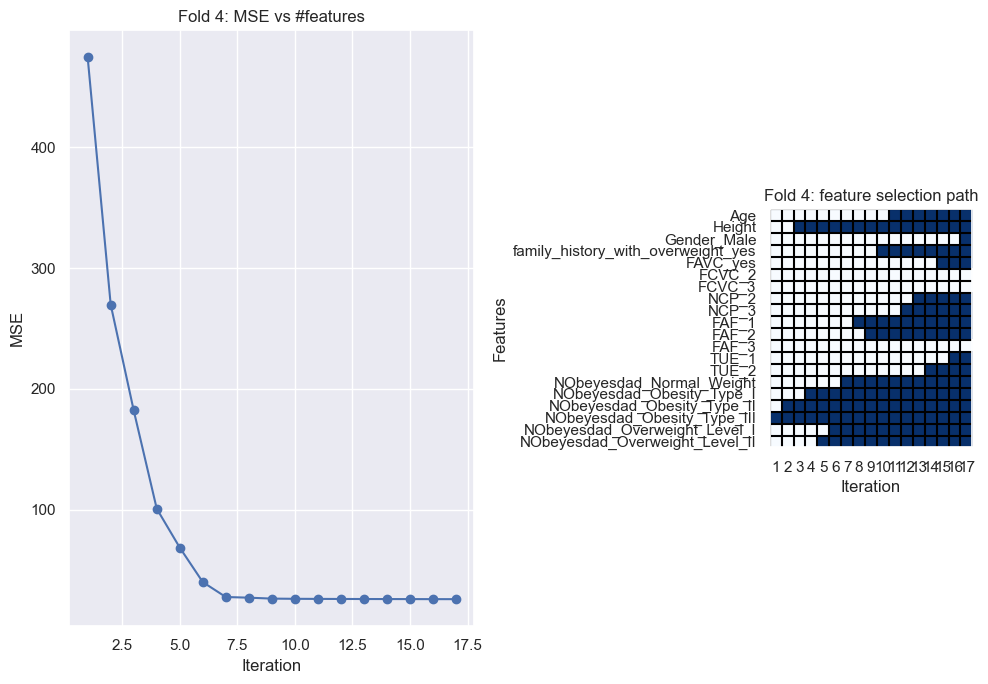

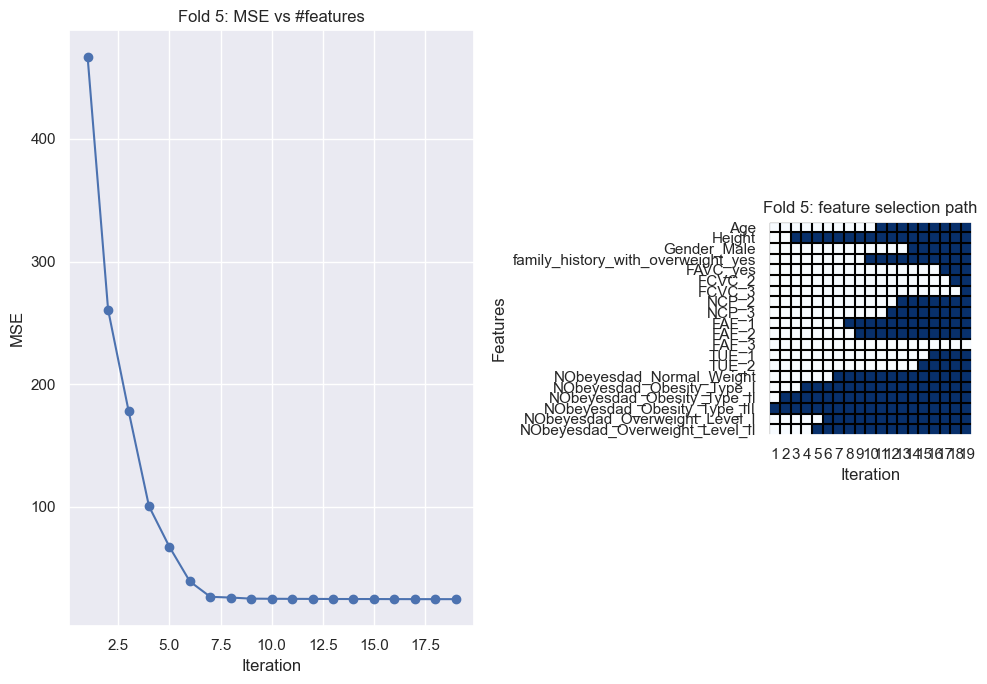

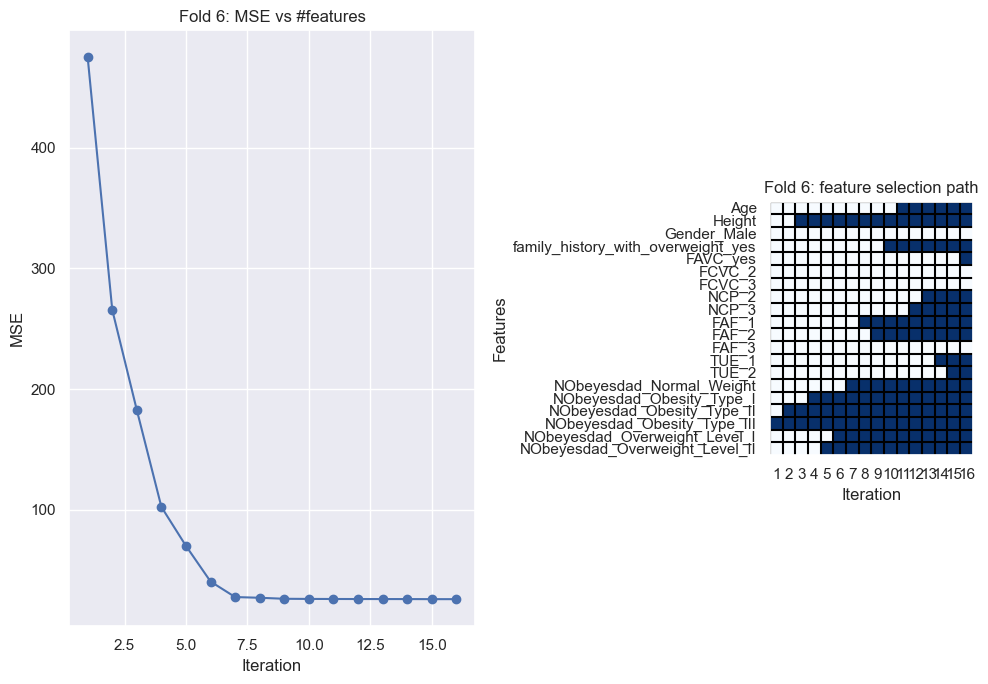

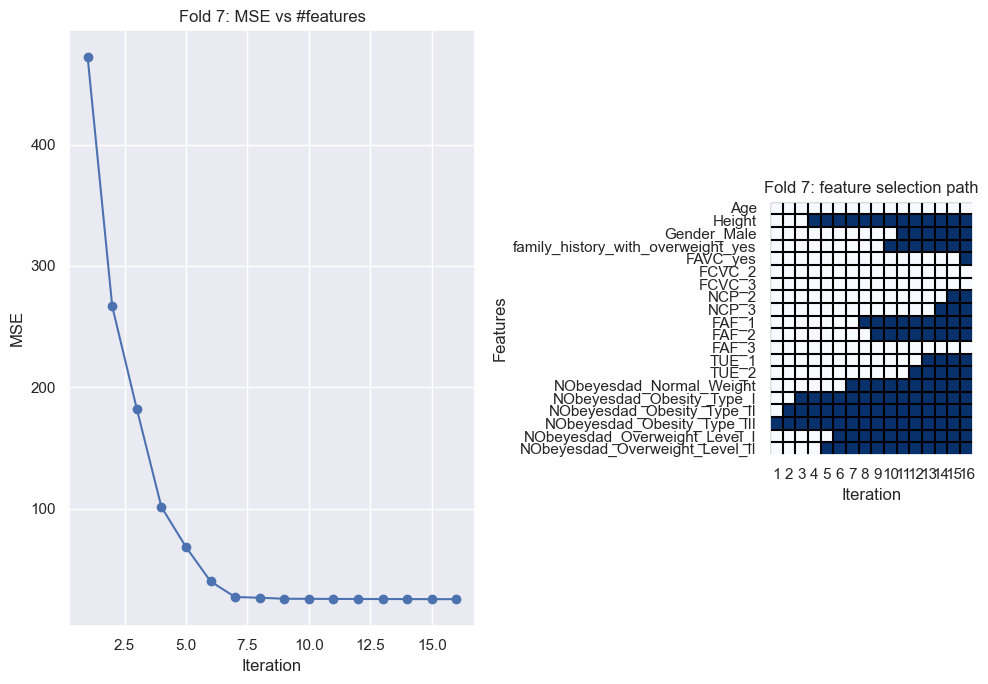

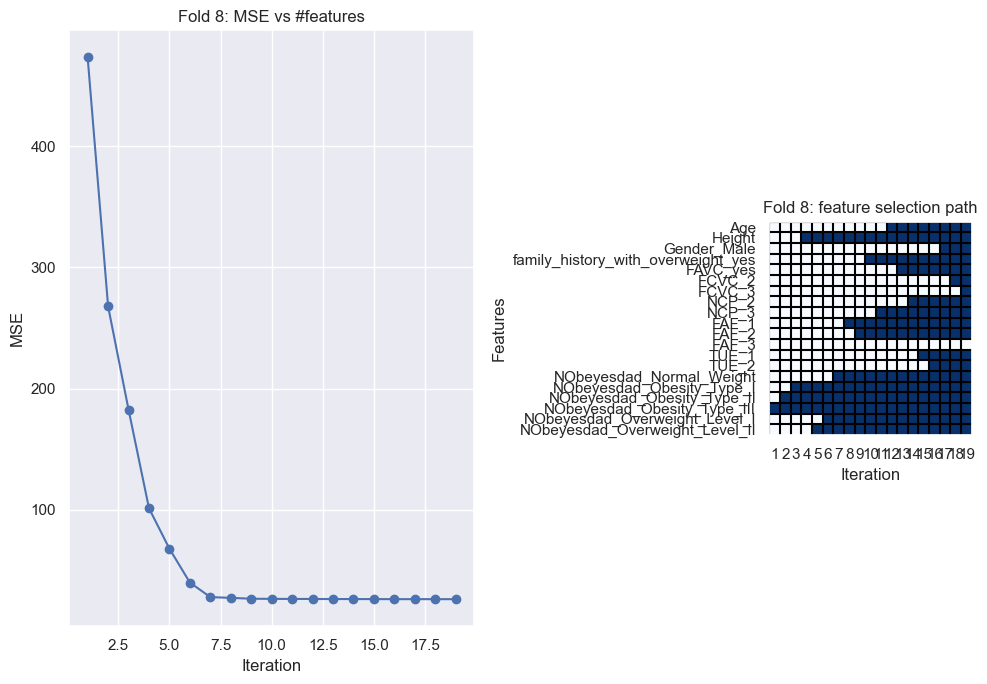

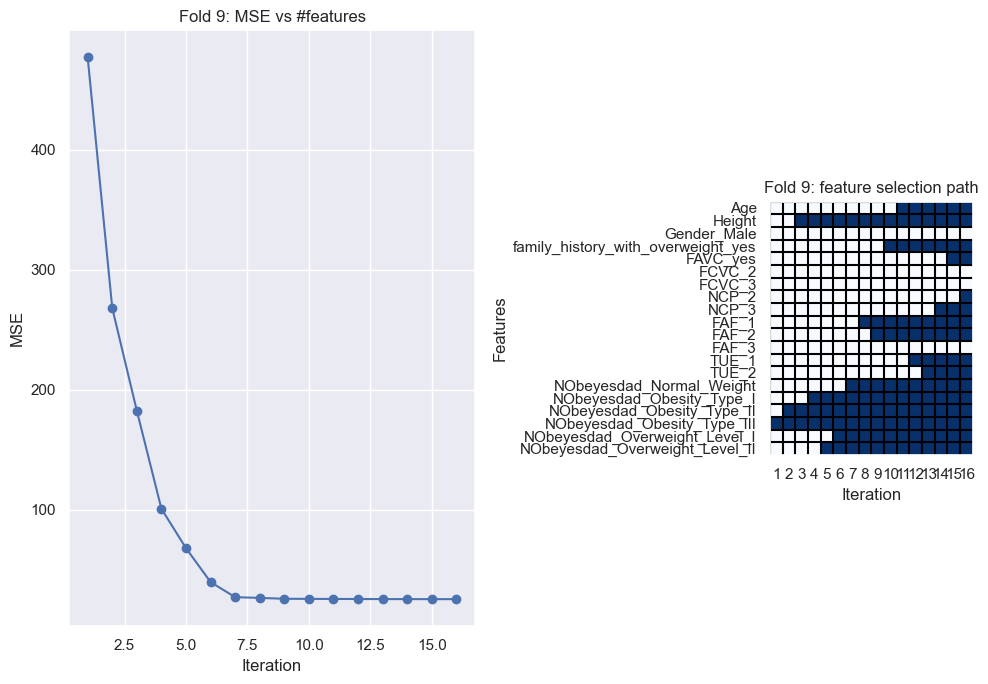

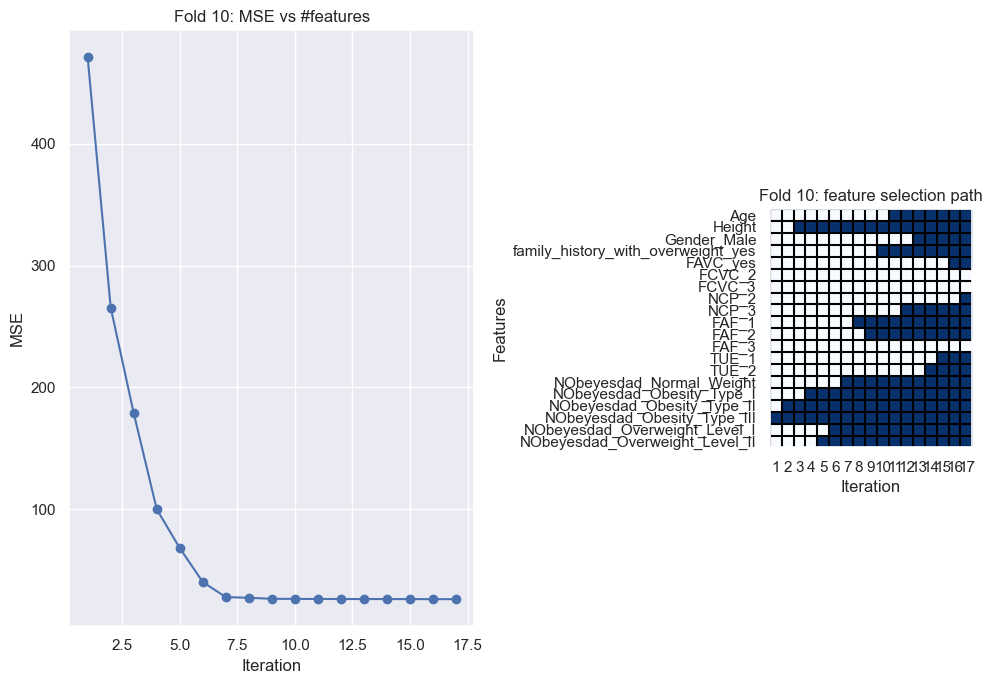

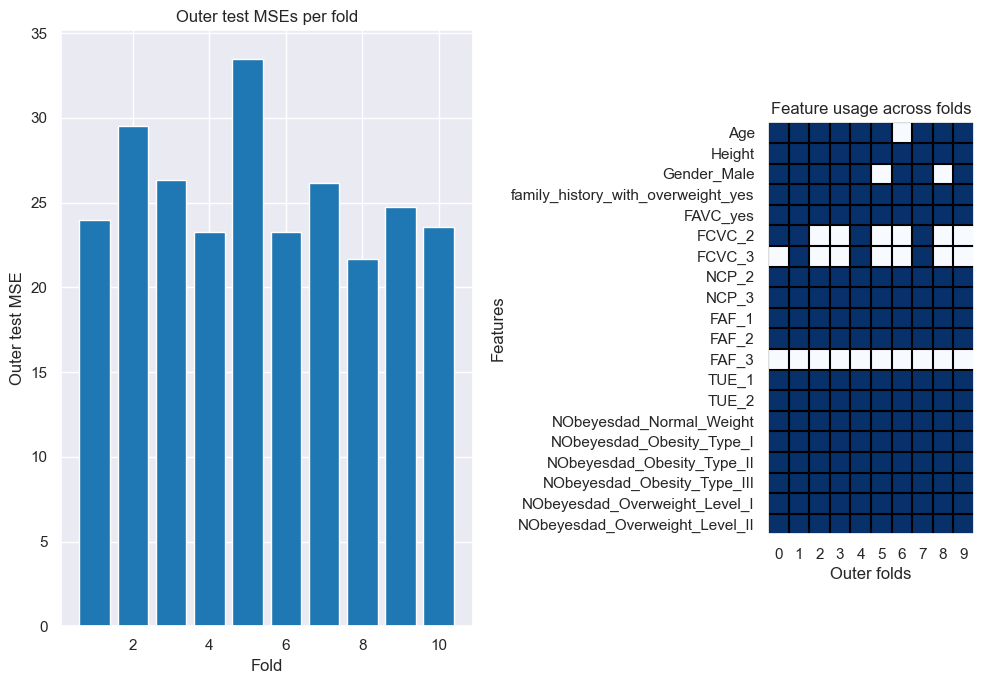

In [83]:
def sequential_feature_selection(X, y, outer_folds=10, inner_folds=10, random_state=42):
    CV_outer = KFold(n_splits=outer_folds, shuffle=True, random_state=random_state)

    fold_results = []  # store per-fold feature paths & errors
    outer_test_mse = []

    for outer_train_idx, outer_test_idx in CV_outer.split(X):

        # Split X and y into training/testing data for this outer fold
        # Name them X_train_outer, X_test_outer, y_train_outer, y_test_outer
        X_train_outer, X_test_outer = X.iloc[outer_train_idx], X.iloc[outer_test_idx]
        y_train_outer, y_test_outer = y.iloc[outer_train_idx], y.iloc[outer_test_idx]

        selected_features = []
        mse_per_iteration = []
        remaining_features = list(X.columns)
        best_mse = np.inf

        # Feature addition while-loop, keep adding features until no improvement
        while remaining_features:
            feature_mse = {}

            for feat in remaining_features:
                candidate_features = selected_features + [feat]

                # inner CV
                CV_inner = KFold(n_splits=inner_folds, shuffle=True, random_state=random_state)
                inner_mse = []

                for inner_train_idx, inner_test_idx in CV_inner.split(X_train_outer):

                    # Split X_train_outer and y_train_outer into training/testing data for this inner fold.
                    # Name them X_train_inner, X_test_inner, y_train_inner, y_test_inner
                    X_train_inner, X_test_inner = X_train_outer.iloc[inner_train_idx], X_train_outer.iloc[inner_test_idx]
                    y_train_inner, y_test_inner = y_train_outer.iloc[inner_train_idx], y_train_outer.iloc[inner_test_idx]
                    
                    # Create Linear Regression model, fit, and predict on the inner sets
                    # - save predictions as y_test_inner_pred.
                    # Remember to only take the candidate_features into consideration.
                    model = LinearRegression(fit_intercept=True)
                    model.fit(X_train_inner[candidate_features], y_train_inner)
                    y_test_inner_pred = model.predict(X_test_inner[candidate_features])
        
                    # Add score for this fold
                    inner_mse.append(mean_squared_error(y_test_inner, y_test_inner_pred))

                # Save average MSE with this feature added
                feature_mse[feat] = np.mean(inner_mse)

            # pick best new feature
            best_feat = min(feature_mse, key=feature_mse.get)
            best_feat_mse = feature_mse[best_feat]

            # If best feature improves MSE, add it
            if best_feat_mse < best_mse:
                selected_features.append(best_feat)
                mse_per_iteration.append(best_feat_mse)
                best_mse = best_feat_mse
                remaining_features.remove(best_feat)

            else: # No improvement - get actual test MSE for outer loop, with best feature set.
                # Create Linear Regression model, fit, and predict on the outer sets
                # - save predictions as y_test_outer_pred.
                # Remember to only take the selected_features into consideration.
                model = LinearRegression(fit_intercept=True)
                model.fit(X_train_outer[selected_features], y_train_outer)
                y_test_outer_pred = model.predict(X_test_outer[selected_features])

                outer_test_mse = mean_squared_error(y_test_outer, y_test_outer_pred)
                break # Break out of while loop

        fold_results.append({
            "mse": mse_per_iteration,
            "features": selected_features,
            "outer_test_mse": outer_test_mse
        })
    return fold_results

results = sequential_feature_selection(X, y, random_state=1)
plot_seq_feature_results(results, list(X.columns))